In [ ]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, CyclicLR
from functools import partial
%matplotlib inline

cv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [ ]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [ ]:
# calculate mean and standard deviation

m = np.mean(train_set.data, axis=(0,1,2))
print(m/255)

s = np.std(train_set.data, axis=(0, 1, 2))
print(s/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [ ]:
mean = m/255
sdev = s/255

In [ ]:
SEED = 101

BATCH = 1024

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [ ]:
from google.colab import files

In [ ]:
# def plot_misclassified_images(images, true_labels, predicted_labels, grid_cols):
#     grid_rows = (len(images) - 1) // grid_cols + 1
#     fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(12, 12))

#     for i in range(len(images)):
#         row = i // grid_cols
#         col = i % grid_cols

#         image = images[i]
#         label_true = true_labels[i].item()
#         label_pred = predicted_labels[i].item()

#         axs[row, col].imshow(image, cmap='gray')
#         axs[row, col].set_title(f'True: {label_true}, Predicted: {label_pred}')
#         axs[row, col].axis('off')

#     plt.tight_layout()
#     plt.show()

In [ ]:
def plot_misclassified_images(incorrect_examples, incorrect_labels, incorrect_preds):
    fig = plt.figure(figsize=(20, 8))

    for idx in np.arange(10):
      ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
      #std = np.array([0.229, 0.224, 0.225])
      #mean = np.array([0.485, 0.456, 0.406])
      img = incorrect_examples[idx][idx]
      img = img/2 + 0.5
      img = np.clip(img, 0, 1)
      imshow(img)
      ax.set_title(f"{classes[pred[idx]]}: x%\n (label: {classes[target[idx]]})",
      color=("green" if pred[idx]==target[idx].item() else "red"))

In [ ]:
incorrect_examples = []
incorrect_labels = []
incorrect_preds = []

In [ ]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1, test=False, test_loader=None, scheduler=None):
    counter = 0
    model_name = None
    model.train() # set the train mode

    test_acc_window = [0,0,0]

    # iterate over for `epochs` epochs and keep storing valuable info

    for epoch in range(epochs):
      correct = processed = train_loss = 0
    #   if scheduler:
    #     scheduler.step()

      print(f"\n epoch num ================================= {epoch+1} out of {epochs} epochs")

      pbar = tqdm(train_loader)

      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device) # move data to `device`

          optimizer.zero_grad() # zero out the gradients to avoid accumulating them over loops

          output = model(data) # get the model's predictions

          loss = F.nll_loss(output, target) # calculate Negative Log Likelihood loss using ground truth labels and the model's predictions

          train_loss += loss.item() # add up the train loss

          loss.backward() # boom ! The magic function to perform backpropagation and calculate the gradients

          optimizer.step() # take 1 step for the optimizer and update the weights

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

          correct += pred.eq(target.view_as(pred)).sum().item() #  compare and see how many predictions are coorect and then add up the count

          processed += len(data) # total processed data size

      acc = 100 * correct/processed

      train_losses.append(train_loss)

      train_accuracy.append(acc)

      if scheduler:
        print("\n\n\t\t\tLast LR -->", scheduler.get_last_lr())
        scheduler.step()

      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


      train_loss /= len(train_loader.dataset)
      print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct,
                                                              len(train_loader.dataset),
                                                              correct * 100 / len(train_loader.dataset)))

      if test: # moving to evaluation
          model.eval() # set the correct mode

          correct = test_loss = 0

          with torch.no_grad(): # to disable gradient calculation with no_grad context

              for data, target in test_loader:

                  data, target = data.to(device), target.to(device)

                  output = model(data)

                  test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

                  correct += pred.eq(target.view_as(pred)).sum().item()




          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          curr_test_acc = 100. * correct / len(test_loader.dataset)
          test_accuracy.append(curr_test_acc)

          test_acc_window[counter % 3] = curr_test_acc
          counter = counter + 1

          if curr_test_acc >= 85.0:
              print(f"\nStoring misclassified images at: {curr_test_acc}% at epoch: {epoch}")
              misclassified_mask = ((pred == target.view_as(pred)) == False).view(-1)

              if misclassified_mask.numel():
                  incorrect_examples.append(data[misclassified_mask].squeeze().cpu().numpy())
                  incorrect_labels.append(target[misclassified_mask].cpu().numpy()) #the corresponding target to the misclassified image
                  incorrect_preds.append(pred[misclassified_mask].squeeze().cpu().numpy()) #the corresponiding predicted class of the misclassified image


          if curr_test_acc > 85.0:
              if all(x > 85.0 for x in test_acc_window):
                  model_name = f"./85_crossed_{counter}.pth"
                  torch.save(model, model_name)


          print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))
    if model_name:
        files.download(model_name)

In [ ]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):

    # Plot for accuracy

    plt.figure(figsize=(10, 5))

    plt.plot(train_accuracy, label='Training Accuracy', color='blue')

    plt.plot(test_accuracy, label='Test Accuracy', color='orange')

    plt.title('Accuracy')

    plt.xlabel('Epoch')

    plt.ylabel('Accuracy')

    plt.legend(loc='upper right')

    plt.grid(True)

    plt.show()



    # Plot for loss

    plt.figure(figsize=(10, 5))

    plt.plot(train_losses, label='Training Loss', color='green')

    plt.plot(test_losses, label='Test Loss', color='red')

    plt.title('Loss')

    plt.xlabel('Epoch')

    plt.ylabel('Loss')

    plt.legend(loc='upper right')

    plt.grid(True)

    plt.show()

In [ ]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [ ]:
# transforms

# here changed CoarseDropout's p to 0.25 from default 0.5, along with minor change in MedianBlur value and HSV' value
train_transforms = A.Compose([
                                A.Normalize(mean=mean, std=sdev,always_apply=True),
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15,rotate_limit=30, p=0.3),
                                A.CoarseDropout(max_holes=1, p=0.2, max_height=16,
                                                max_width=16, min_holes=1, min_height=16,
                                                min_width=16, fill_value=mean),
                                A.ColorJitter(brightness=0.2, contrast=0.2,saturation=0.2, p=0.1),
                                ToTensorV2()
                                       ])

test_transforms = A.Compose([
                            A.Normalize(mean=mean, std=sdev, always_apply=True),
                            ToTensorV2()
                                    ])


In [ ]:

# data sets with transforms

train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets

train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([1024, 3, 32, 32])
torch.Size([1024])


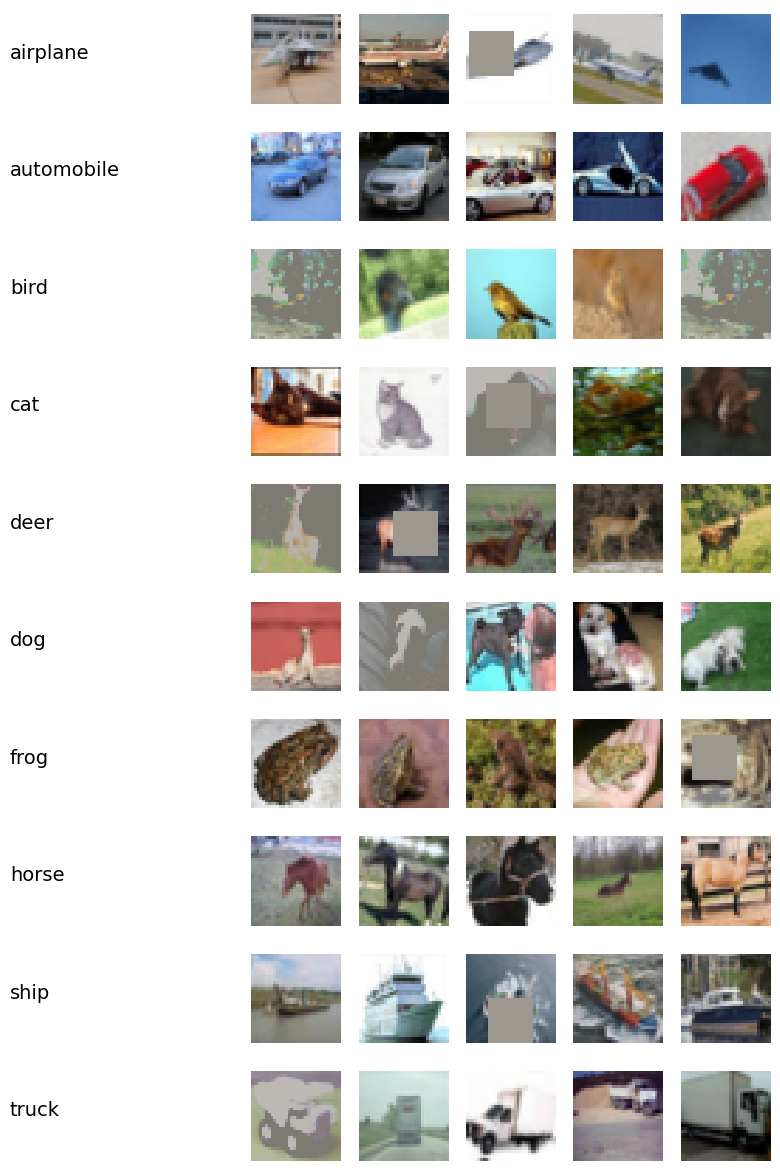

In [ ]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)

  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]

  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category.
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [ ]:
class Net_new_3(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            cv(3, 32, 3, padding=1),
            relu(),
            bn(32),
            cv(32, 32, 3, dilation=1, padding=1, stride=1),
            relu(),
            bn(32),
            cv(32, 32, 3, dilation=1, padding=2, stride=2),
            relu(),
            bn(32)
        )

        self.block2 = nn.Sequential(
            cv(32, 64, 3, padding=2, dilation=1, groups=8),
            relu(),
            bn(64),
            cv(64, 32, 3, dilation=1, padding=1, groups=8),
            relu(),
            bn(32),
            cv(32, 32, 1),  # 1x1
            cv(32, 32, 3, padding=2, dilation=1, groups=8, stride=2),
            relu(),
            bn(32)
        )

        self.block3 = nn.Sequential(
            cv(32, 64, 3, dilation=1, padding=2, groups=16, stride=1),
            relu(),
            bn(64),
            cv(64, 64, 3, padding=2, groups=64),
            cv(64, 64, 1, padding=0),
            relu(),
            bn(64),
            cv(64, 32, 1),  # 1x1
            cv(32, 64, 3, padding=2, dilation=2, stride=2, groups=16),
            relu(),
            bn(64)
            )

        self.block4 = nn.Sequential(
            cv(64, 128, 3, padding=1, groups=16, stride=1, dilation=1),
            bn(128),
            relu(),
            # cv(128, 64, 1),  # 1x1
            cv(128, 128, 3, groups=64, padding=1), # depthwise (a)
            cv(128, 64, 1), # pointwise for preceding depthwise (b)
            bn(64),
            relu(),
            cv(64, 64, 3, dilation=2,padding=2, stride=2),
            cv(64, 16, 1),
            bn(16),
            relu(),
            )

        self.final_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            cv(16, 10, 1),  # 1x1
        )


    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.final_block(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


model3 = Net_new_3().to(device)
summary(model3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,216
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 17, 17]           9,216
              ReLU-8           [-1, 32, 17, 17]               0
       BatchNorm2d-9           [-1, 32, 17, 17]              64
           Conv2d-10           [-1, 64, 19, 19]           2,304
             ReLU-11           [-1, 64, 19, 19]               0
      BatchNorm2d-12           [-1, 64, 19, 19]             128
           Conv2d-13           [-1, 32, 19, 19]           2,304
             ReLU-14           [-1, 32,

In [ ]:
model3 = Net_new_3().to(device)

optimizer = optim.SGD(model3.parameters(), lr=0.013, momentum=0.9, nesterov=True)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

train_eval_model(model3, train_loader, optimizer, device, epochs=100, test=True, test_loader=test_loader, scheduler = None)



 epoch num ================================= 1 out of 100 epochs


100%|██████████| 49/49 [00:14<00:00,  3.28it/s]


			Train metrics: accuracy: 8227/50000 (16.4540%)



	Test metrics: average loss: 2.1334, accuracy: 2144/10000 (21.44000%)


 epoch num ================================= 2 out of 100 epochs


100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


			Train metrics: accuracy: 12808/50000 (25.6160%)



	Test metrics: average loss: 1.9719, accuracy: 2321/10000 (23.21000%)


 epoch num ================================= 3 out of 100 epochs


100%|██████████| 49/49 [00:11<00:00,  4.14it/s]


			Train metrics: accuracy: 15216/50000 (30.4320%)



	Test metrics: average loss: 1.6696, accuracy: 3730/10000 (37.30000%)


 epoch num ================================= 4 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.23it/s]


			Train metrics: accuracy: 17825/50000 (35.6500%)



	Test metrics: average loss: 1.5349, accuracy: 4187/10000 (41.87000%)


 epoch num ================================= 5 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.61it/s]


			Train metrics: accuracy: 19666/50000 (39.3320%)



	Test metrics: average loss: 1.5003, accuracy: 4349/10000 (43.49000%)


 epoch num ================================= 6 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.55it/s]


			Train metrics: accuracy: 20914/50000 (41.8280%)



	Test metrics: average loss: 1.4048, accuracy: 4740/10000 (47.40000%)


 epoch num ================================= 7 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.65it/s]


			Train metrics: accuracy: 21952/50000 (43.9040%)



	Test metrics: average loss: 1.4897, accuracy: 4382/10000 (43.82000%)


 epoch num ================================= 8 out of 100 epochs


100%|██████████| 49/49 [00:11<00:00,  4.21it/s]


			Train metrics: accuracy: 22883/50000 (45.7660%)



	Test metrics: average loss: 1.4919, accuracy: 4579/10000 (45.79000%)


 epoch num ================================= 9 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.61it/s]


			Train metrics: accuracy: 23940/50000 (47.8800%)



	Test metrics: average loss: 1.2598, accuracy: 5378/10000 (53.78000%)


 epoch num ================================= 10 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.49it/s]


			Train metrics: accuracy: 24663/50000 (49.3260%)



	Test metrics: average loss: 1.2248, accuracy: 5671/10000 (56.71000%)


 epoch num ================================= 11 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.11it/s]


			Train metrics: accuracy: 25936/50000 (51.8720%)



	Test metrics: average loss: 1.2180, accuracy: 5598/10000 (55.98000%)


 epoch num ================================= 12 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]


			Train metrics: accuracy: 26469/50000 (52.9380%)



	Test metrics: average loss: 1.1225, accuracy: 5890/10000 (58.90000%)


 epoch num ================================= 13 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 27033/50000 (54.0660%)



	Test metrics: average loss: 1.0927, accuracy: 6109/10000 (61.09000%)


 epoch num ================================= 14 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.60it/s]


			Train metrics: accuracy: 26843/50000 (53.6860%)



	Test metrics: average loss: 1.0640, accuracy: 6183/10000 (61.83000%)


 epoch num ================================= 15 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.68it/s]


			Train metrics: accuracy: 28220/50000 (56.4400%)



	Test metrics: average loss: 1.2541, accuracy: 5504/10000 (55.04000%)


 epoch num ================================= 16 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.77it/s]


			Train metrics: accuracy: 28485/50000 (56.9700%)



	Test metrics: average loss: 1.0419, accuracy: 6222/10000 (62.22000%)


 epoch num ================================= 17 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.21it/s]


			Train metrics: accuracy: 29293/50000 (58.5860%)



	Test metrics: average loss: 0.9869, accuracy: 6460/10000 (64.60000%)


 epoch num ================================= 18 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]


			Train metrics: accuracy: 29720/50000 (59.4400%)



	Test metrics: average loss: 0.9853, accuracy: 6448/10000 (64.48000%)


 epoch num ================================= 19 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.54it/s]


			Train metrics: accuracy: 29894/50000 (59.7880%)



	Test metrics: average loss: 0.9360, accuracy: 6639/10000 (66.39000%)


 epoch num ================================= 20 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 29925/50000 (59.8500%)



	Test metrics: average loss: 0.9337, accuracy: 6668/10000 (66.68000%)


 epoch num ================================= 21 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.56it/s]


			Train metrics: accuracy: 30729/50000 (61.4580%)



	Test metrics: average loss: 0.9129, accuracy: 6730/10000 (67.30000%)


 epoch num ================================= 22 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]


			Train metrics: accuracy: 31165/50000 (62.3300%)



	Test metrics: average loss: 0.8879, accuracy: 6826/10000 (68.26000%)


 epoch num ================================= 23 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.29it/s]


			Train metrics: accuracy: 31380/50000 (62.7600%)



	Test metrics: average loss: 0.8911, accuracy: 6805/10000 (68.05000%)


 epoch num ================================= 24 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.07it/s]


			Train metrics: accuracy: 31396/50000 (62.7920%)



	Test metrics: average loss: 0.8750, accuracy: 6848/10000 (68.48000%)


 epoch num ================================= 25 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 31878/50000 (63.7560%)



	Test metrics: average loss: 0.8652, accuracy: 6900/10000 (69.00000%)


 epoch num ================================= 26 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]



			Train metrics: accuracy: 32155/50000 (64.3100%)

	Test metrics: average loss: 0.8416, accuracy: 7060/10000 (70.60000%)


 epoch num ================================= 27 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]


			Train metrics: accuracy: 32166/50000 (64.3320%)



	Test metrics: average loss: 0.8337, accuracy: 7036/10000 (70.36000%)


 epoch num ================================= 28 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 32663/50000 (65.3260%)



	Test metrics: average loss: 0.8114, accuracy: 7137/10000 (71.37000%)


 epoch num ================================= 29 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.06it/s]


			Train metrics: accuracy: 32796/50000 (65.5920%)



	Test metrics: average loss: 0.8230, accuracy: 7057/10000 (70.57000%)


 epoch num ================================= 30 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]


			Train metrics: accuracy: 33041/50000 (66.0820%)



	Test metrics: average loss: 0.8381, accuracy: 7034/10000 (70.34000%)


 epoch num ================================= 31 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.50it/s]


			Train metrics: accuracy: 33233/50000 (66.4660%)



	Test metrics: average loss: 0.7885, accuracy: 7196/10000 (71.96000%)


 epoch num ================================= 32 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.48it/s]


			Train metrics: accuracy: 33193/50000 (66.3860%)



	Test metrics: average loss: 0.8034, accuracy: 7117/10000 (71.17000%)


 epoch num ================================= 33 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.68it/s]



			Train metrics: accuracy: 33540/50000 (67.0800%)

	Test metrics: average loss: 0.8089, accuracy: 7120/10000 (71.20000%)


 epoch num ================================= 34 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]


			Train metrics: accuracy: 33337/50000 (66.6740%)



	Test metrics: average loss: 0.7986, accuracy: 7161/10000 (71.61000%)


 epoch num ================================= 35 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


			Train metrics: accuracy: 33699/50000 (67.3980%)



	Test metrics: average loss: 0.8222, accuracy: 7121/10000 (71.21000%)


 epoch num ================================= 36 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.24it/s]


			Train metrics: accuracy: 33908/50000 (67.8160%)



	Test metrics: average loss: 0.7687, accuracy: 7265/10000 (72.65000%)


 epoch num ================================= 37 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


			Train metrics: accuracy: 34020/50000 (68.0400%)



	Test metrics: average loss: 0.7574, accuracy: 7346/10000 (73.46000%)


 epoch num ================================= 38 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.70it/s]


			Train metrics: accuracy: 34342/50000 (68.6840%)



	Test metrics: average loss: 0.7518, accuracy: 7338/10000 (73.38000%)


 epoch num ================================= 39 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 34290/50000 (68.5800%)



	Test metrics: average loss: 0.7851, accuracy: 7232/10000 (72.32000%)


 epoch num ================================= 40 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.58it/s]



			Train metrics: accuracy: 34422/50000 (68.8440%)

	Test metrics: average loss: 0.7191, accuracy: 7488/10000 (74.88000%)


 epoch num ================================= 41 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.70it/s]


			Train metrics: accuracy: 34714/50000 (69.4280%)



	Test metrics: average loss: 0.8049, accuracy: 7188/10000 (71.88000%)


 epoch num ================================= 42 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.17it/s]


			Train metrics: accuracy: 34671/50000 (69.3420%)



	Test metrics: average loss: 0.7716, accuracy: 7296/10000 (72.96000%)


 epoch num ================================= 43 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.03it/s]


			Train metrics: accuracy: 34739/50000 (69.4780%)



	Test metrics: average loss: 0.7288, accuracy: 7444/10000 (74.44000%)


 epoch num ================================= 44 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 34908/50000 (69.8160%)



	Test metrics: average loss: 0.7311, accuracy: 7440/10000 (74.40000%)


 epoch num ================================= 45 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.60it/s]



			Train metrics: accuracy: 35107/50000 (70.2140%)

	Test metrics: average loss: 0.7095, accuracy: 7479/10000 (74.79000%)


 epoch num ================================= 46 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]


			Train metrics: accuracy: 35179/50000 (70.3580%)



	Test metrics: average loss: 0.7703, accuracy: 7338/10000 (73.38000%)


 epoch num ================================= 47 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 35300/50000 (70.6000%)



	Test metrics: average loss: 0.7306, accuracy: 7483/10000 (74.83000%)


 epoch num ================================= 48 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.14it/s]


			Train metrics: accuracy: 35304/50000 (70.6080%)



	Test metrics: average loss: 0.7226, accuracy: 7447/10000 (74.47000%)


 epoch num ================================= 49 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.14it/s]


			Train metrics: accuracy: 35547/50000 (71.0940%)



	Test metrics: average loss: 0.7307, accuracy: 7490/10000 (74.90000%)


 epoch num ================================= 50 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.61it/s]


			Train metrics: accuracy: 35446/50000 (70.8920%)



	Test metrics: average loss: 0.7274, accuracy: 7468/10000 (74.68000%)


 epoch num ================================= 51 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 35555/50000 (71.1100%)



	Test metrics: average loss: 0.7464, accuracy: 7394/10000 (73.94000%)


 epoch num ================================= 52 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.68it/s]


			Train metrics: accuracy: 35896/50000 (71.7920%)



	Test metrics: average loss: 0.6689, accuracy: 7655/10000 (76.55000%)


 epoch num ================================= 53 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.69it/s]


			Train metrics: accuracy: 35829/50000 (71.6580%)



	Test metrics: average loss: 0.7368, accuracy: 7431/10000 (74.31000%)


 epoch num ================================= 54 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.21it/s]


			Train metrics: accuracy: 35611/50000 (71.2220%)



	Test metrics: average loss: 0.6900, accuracy: 7615/10000 (76.15000%)


 epoch num ================================= 55 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.09it/s]


			Train metrics: accuracy: 36065/50000 (72.1300%)



	Test metrics: average loss: 0.6951, accuracy: 7601/10000 (76.01000%)


 epoch num ================================= 56 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.63it/s]



			Train metrics: accuracy: 36004/50000 (72.0080%)

	Test metrics: average loss: 0.6821, accuracy: 7606/10000 (76.06000%)


 epoch num ================================= 57 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.58it/s]


			Train metrics: accuracy: 36225/50000 (72.4500%)



	Test metrics: average loss: 0.6727, accuracy: 7698/10000 (76.98000%)


 epoch num ================================= 58 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.65it/s]



			Train metrics: accuracy: 36187/50000 (72.3740%)

	Test metrics: average loss: 0.6801, accuracy: 7641/10000 (76.41000%)


 epoch num ================================= 59 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.65it/s]


			Train metrics: accuracy: 36427/50000 (72.8540%)



	Test metrics: average loss: 0.6746, accuracy: 7658/10000 (76.58000%)


 epoch num ================================= 60 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.14it/s]


			Train metrics: accuracy: 36478/50000 (72.9560%)



	Test metrics: average loss: 0.6627, accuracy: 7675/10000 (76.75000%)


 epoch num ================================= 61 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]


			Train metrics: accuracy: 36471/50000 (72.9420%)



	Test metrics: average loss: 0.6753, accuracy: 7692/10000 (76.92000%)


 epoch num ================================= 62 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.57it/s]


			Train metrics: accuracy: 36516/50000 (73.0320%)



	Test metrics: average loss: 0.6563, accuracy: 7707/10000 (77.07000%)


 epoch num ================================= 63 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.65it/s]


			Train metrics: accuracy: 36632/50000 (73.2640%)



	Test metrics: average loss: 0.6518, accuracy: 7735/10000 (77.35000%)


 epoch num ================================= 64 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]


			Train metrics: accuracy: 36761/50000 (73.5220%)



	Test metrics: average loss: 0.6532, accuracy: 7696/10000 (76.96000%)


 epoch num ================================= 65 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]


			Train metrics: accuracy: 36849/50000 (73.6980%)



	Test metrics: average loss: 0.6545, accuracy: 7720/10000 (77.20000%)


 epoch num ================================= 66 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.09it/s]


			Train metrics: accuracy: 36829/50000 (73.6580%)



	Test metrics: average loss: 0.7015, accuracy: 7605/10000 (76.05000%)


 epoch num ================================= 67 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]


			Train metrics: accuracy: 36757/50000 (73.5140%)



	Test metrics: average loss: 0.6415, accuracy: 7772/10000 (77.72000%)


 epoch num ================================= 68 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


			Train metrics: accuracy: 36702/50000 (73.4040%)



	Test metrics: average loss: 0.6689, accuracy: 7688/10000 (76.88000%)


 epoch num ================================= 69 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.58it/s]


			Train metrics: accuracy: 36900/50000 (73.8000%)



	Test metrics: average loss: 0.6692, accuracy: 7710/10000 (77.10000%)


 epoch num ================================= 70 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]


			Train metrics: accuracy: 36997/50000 (73.9940%)



	Test metrics: average loss: 0.6223, accuracy: 7812/10000 (78.12000%)


 epoch num ================================= 71 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.61it/s]


			Train metrics: accuracy: 37079/50000 (74.1580%)



	Test metrics: average loss: 0.6351, accuracy: 7787/10000 (77.87000%)


 epoch num ================================= 72 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 37181/50000 (74.3620%)



	Test metrics: average loss: 0.6606, accuracy: 7717/10000 (77.17000%)


 epoch num ================================= 73 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.24it/s]


			Train metrics: accuracy: 37413/50000 (74.8260%)



	Test metrics: average loss: 0.6418, accuracy: 7824/10000 (78.24000%)


 epoch num ================================= 74 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]


			Train metrics: accuracy: 37255/50000 (74.5100%)



	Test metrics: average loss: 0.6176, accuracy: 7838/10000 (78.38000%)


 epoch num ================================= 75 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]


			Train metrics: accuracy: 37369/50000 (74.7380%)



	Test metrics: average loss: 0.6107, accuracy: 7880/10000 (78.80000%)


 epoch num ================================= 76 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.50it/s]


			Train metrics: accuracy: 37422/50000 (74.8440%)



	Test metrics: average loss: 0.6125, accuracy: 7861/10000 (78.61000%)


 epoch num ================================= 77 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.51it/s]


			Train metrics: accuracy: 37371/50000 (74.7420%)



	Test metrics: average loss: 0.5925, accuracy: 7946/10000 (79.46000%)


 epoch num ================================= 78 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.52it/s]


			Train metrics: accuracy: 37756/50000 (75.5120%)



	Test metrics: average loss: 0.6161, accuracy: 7847/10000 (78.47000%)


 epoch num ================================= 79 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.73it/s]


			Train metrics: accuracy: 37499/50000 (74.9980%)



	Test metrics: average loss: 0.6276, accuracy: 7847/10000 (78.47000%)


 epoch num ================================= 80 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


			Train metrics: accuracy: 37585/50000 (75.1700%)



	Test metrics: average loss: 0.6051, accuracy: 7933/10000 (79.33000%)


 epoch num ================================= 81 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


			Train metrics: accuracy: 37632/50000 (75.2640%)



	Test metrics: average loss: 0.6444, accuracy: 7804/10000 (78.04000%)


 epoch num ================================= 82 out of 100 epochs


100%|██████████| 49/49 [00:11<00:00,  4.35it/s]


			Train metrics: accuracy: 37600/50000 (75.2000%)



	Test metrics: average loss: 0.6057, accuracy: 7853/10000 (78.53000%)


 epoch num ================================= 83 out of 100 epochs


100%|██████████| 49/49 [00:11<00:00,  4.43it/s]


			Train metrics: accuracy: 37687/50000 (75.3740%)



	Test metrics: average loss: 0.6325, accuracy: 7801/10000 (78.01000%)


 epoch num ================================= 84 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.55it/s]


			Train metrics: accuracy: 37852/50000 (75.7040%)



	Test metrics: average loss: 0.6133, accuracy: 7889/10000 (78.89000%)


 epoch num ================================= 85 out of 100 epochs


100%|██████████| 49/49 [00:11<00:00,  4.40it/s]


			Train metrics: accuracy: 37850/50000 (75.7000%)



	Test metrics: average loss: 0.6230, accuracy: 7839/10000 (78.39000%)


 epoch num ================================= 86 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.69it/s]


			Train metrics: accuracy: 37803/50000 (75.6060%)



	Test metrics: average loss: 0.6839, accuracy: 7676/10000 (76.76000%)


 epoch num ================================= 87 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.06it/s]


			Train metrics: accuracy: 37970/50000 (75.9400%)



	Test metrics: average loss: 0.6148, accuracy: 7855/10000 (78.55000%)


 epoch num ================================= 88 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.76it/s]


			Train metrics: accuracy: 37960/50000 (75.9200%)



	Test metrics: average loss: 0.6066, accuracy: 7866/10000 (78.66000%)


 epoch num ================================= 89 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]


			Train metrics: accuracy: 38096/50000 (76.1920%)



	Test metrics: average loss: 0.5998, accuracy: 7895/10000 (78.95000%)


 epoch num ================================= 90 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.51it/s]



			Train metrics: accuracy: 37994/50000 (75.9880%)

	Test metrics: average loss: 0.5956, accuracy: 7955/10000 (79.55000%)


 epoch num ================================= 91 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.58it/s]


			Train metrics: accuracy: 38141/50000 (76.2820%)



	Test metrics: average loss: 0.6002, accuracy: 7926/10000 (79.26000%)


 epoch num ================================= 92 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 37989/50000 (75.9780%)



	Test metrics: average loss: 0.6348, accuracy: 7792/10000 (77.92000%)


 epoch num ================================= 93 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


			Train metrics: accuracy: 38206/50000 (76.4120%)



	Test metrics: average loss: 0.5860, accuracy: 8032/10000 (80.32000%)


 epoch num ================================= 94 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.28it/s]


			Train metrics: accuracy: 38146/50000 (76.2920%)



	Test metrics: average loss: 0.5841, accuracy: 8006/10000 (80.06000%)


 epoch num ================================= 95 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.65it/s]


			Train metrics: accuracy: 38246/50000 (76.4920%)



	Test metrics: average loss: 0.5952, accuracy: 7977/10000 (79.77000%)


 epoch num ================================= 96 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.55it/s]


			Train metrics: accuracy: 38121/50000 (76.2420%)



	Test metrics: average loss: 0.5825, accuracy: 7977/10000 (79.77000%)


 epoch num ================================= 97 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]


			Train metrics: accuracy: 38307/50000 (76.6140%)



	Test metrics: average loss: 0.5805, accuracy: 8000/10000 (80.00000%)


 epoch num ================================= 98 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.56it/s]


			Train metrics: accuracy: 38232/50000 (76.4640%)



	Test metrics: average loss: 0.5826, accuracy: 7974/10000 (79.74000%)


 epoch num ================================= 99 out of 100 epochs


100%|██████████| 49/49 [00:10<00:00,  4.60it/s]


			Train metrics: accuracy: 38455/50000 (76.9100%)



	Test metrics: average loss: 0.5762, accuracy: 8044/10000 (80.44000%)


 epoch num ================================= 100 out of 100 epochs


100%|██████████| 49/49 [00:09<00:00,  5.19it/s]


			Train metrics: accuracy: 38404/50000 (76.8080%)



	Test metrics: average loss: 0.6470, accuracy: 7772/10000 (77.72000%)



In [ ]:
optimizer = optim.Adam(model3.parameters(),lr=0.00357)

train_eval_model(model3, train_loader, optimizer, device, epochs=120, test=True, test_loader=test_loader, scheduler=None)



 epoch num ================================= 1 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]


			Train metrics: accuracy: 32496/50000 (64.9920%)



	Test metrics: average loss: 0.8030, accuracy: 7410/10000 (74.10000%)


 epoch num ================================= 2 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.70it/s]


			Train metrics: accuracy: 28641/50000 (57.2820%)



	Test metrics: average loss: 0.7591, accuracy: 7343/10000 (73.43000%)


 epoch num ================================= 3 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 34803/50000 (69.6060%)



	Test metrics: average loss: 0.6630, accuracy: 7696/10000 (76.96000%)


 epoch num ================================= 4 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.53it/s]


			Train metrics: accuracy: 35872/50000 (71.7440%)



	Test metrics: average loss: 0.6378, accuracy: 7775/10000 (77.75000%)


 epoch num ================================= 5 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.61it/s]


			Train metrics: accuracy: 36166/50000 (72.3320%)



	Test metrics: average loss: 0.6324, accuracy: 7820/10000 (78.20000%)


 epoch num ================================= 6 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.69it/s]


			Train metrics: accuracy: 36555/50000 (73.1100%)



	Test metrics: average loss: 0.6108, accuracy: 7858/10000 (78.58000%)


 epoch num ================================= 7 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.18it/s]


			Train metrics: accuracy: 36498/50000 (72.9960%)



	Test metrics: average loss: 0.6227, accuracy: 7843/10000 (78.43000%)


 epoch num ================================= 8 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


			Train metrics: accuracy: 36942/50000 (73.8840%)



	Test metrics: average loss: 0.6153, accuracy: 7853/10000 (78.53000%)


 epoch num ================================= 9 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]


			Train metrics: accuracy: 36871/50000 (73.7420%)



	Test metrics: average loss: 0.6066, accuracy: 7890/10000 (78.90000%)


 epoch num ================================= 10 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 37129/50000 (74.2580%)



	Test metrics: average loss: 0.6088, accuracy: 7880/10000 (78.80000%)


 epoch num ================================= 11 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 37317/50000 (74.6340%)



	Test metrics: average loss: 0.6083, accuracy: 7909/10000 (79.09000%)


 epoch num ================================= 12 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.73it/s]


			Train metrics: accuracy: 37373/50000 (74.7460%)



	Test metrics: average loss: 0.6127, accuracy: 7861/10000 (78.61000%)


 epoch num ================================= 13 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.17it/s]


			Train metrics: accuracy: 37626/50000 (75.2520%)



	Test metrics: average loss: 0.5960, accuracy: 7931/10000 (79.31000%)


 epoch num ================================= 14 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.08it/s]


			Train metrics: accuracy: 37629/50000 (75.2580%)



	Test metrics: average loss: 0.5881, accuracy: 7994/10000 (79.94000%)


 epoch num ================================= 15 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.58it/s]


			Train metrics: accuracy: 37707/50000 (75.4140%)



	Test metrics: average loss: 0.5777, accuracy: 7990/10000 (79.90000%)


 epoch num ================================= 16 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.61it/s]


			Train metrics: accuracy: 37714/50000 (75.4280%)



	Test metrics: average loss: 0.6344, accuracy: 7819/10000 (78.19000%)


 epoch num ================================= 17 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]


			Train metrics: accuracy: 38046/50000 (76.0920%)



	Test metrics: average loss: 0.5774, accuracy: 7995/10000 (79.95000%)


 epoch num ================================= 18 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.65it/s]


			Train metrics: accuracy: 37806/50000 (75.6120%)



	Test metrics: average loss: 0.5841, accuracy: 7982/10000 (79.82000%)


 epoch num ================================= 19 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.24it/s]


			Train metrics: accuracy: 37671/50000 (75.3420%)



	Test metrics: average loss: 0.5873, accuracy: 7971/10000 (79.71000%)


 epoch num ================================= 20 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.13it/s]


			Train metrics: accuracy: 37773/50000 (75.5460%)



	Test metrics: average loss: 0.5703, accuracy: 8011/10000 (80.11000%)


 epoch num ================================= 21 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.57it/s]


			Train metrics: accuracy: 38127/50000 (76.2540%)



	Test metrics: average loss: 0.5730, accuracy: 8050/10000 (80.50000%)


 epoch num ================================= 22 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.69it/s]


			Train metrics: accuracy: 38141/50000 (76.2820%)



	Test metrics: average loss: 0.6026, accuracy: 7950/10000 (79.50000%)


 epoch num ================================= 23 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.56it/s]


			Train metrics: accuracy: 38222/50000 (76.4440%)



	Test metrics: average loss: 0.5555, accuracy: 8106/10000 (81.06000%)


 epoch num ================================= 24 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.61it/s]


			Train metrics: accuracy: 38395/50000 (76.7900%)



	Test metrics: average loss: 0.5843, accuracy: 7977/10000 (79.77000%)


 epoch num ================================= 25 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


			Train metrics: accuracy: 38119/50000 (76.2380%)



	Test metrics: average loss: 0.5765, accuracy: 8020/10000 (80.20000%)


 epoch num ================================= 26 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.23it/s]



			Train metrics: accuracy: 38373/50000 (76.7460%)

	Test metrics: average loss: 0.5535, accuracy: 8112/10000 (81.12000%)


 epoch num ================================= 27 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.74it/s]


			Train metrics: accuracy: 38364/50000 (76.7280%)



	Test metrics: average loss: 0.5660, accuracy: 8075/10000 (80.75000%)


 epoch num ================================= 28 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.53it/s]


			Train metrics: accuracy: 38417/50000 (76.8340%)



	Test metrics: average loss: 0.5632, accuracy: 8108/10000 (81.08000%)


 epoch num ================================= 29 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]


			Train metrics: accuracy: 38548/50000 (77.0960%)



	Test metrics: average loss: 0.5560, accuracy: 8080/10000 (80.80000%)


 epoch num ================================= 30 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 38660/50000 (77.3200%)



	Test metrics: average loss: 0.5703, accuracy: 8032/10000 (80.32000%)


 epoch num ================================= 31 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.67it/s]


			Train metrics: accuracy: 38272/50000 (76.5440%)



	Test metrics: average loss: 0.5545, accuracy: 8141/10000 (81.41000%)


 epoch num ================================= 32 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.22it/s]


			Train metrics: accuracy: 38501/50000 (77.0020%)



	Test metrics: average loss: 0.5626, accuracy: 8086/10000 (80.86000%)


 epoch num ================================= 33 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]


			Train metrics: accuracy: 38507/50000 (77.0140%)



	Test metrics: average loss: 0.5629, accuracy: 8041/10000 (80.41000%)


 epoch num ================================= 34 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.67it/s]


			Train metrics: accuracy: 38779/50000 (77.5580%)



	Test metrics: average loss: 0.5444, accuracy: 8127/10000 (81.27000%)


 epoch num ================================= 35 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 38774/50000 (77.5480%)



	Test metrics: average loss: 0.5796, accuracy: 8031/10000 (80.31000%)


 epoch num ================================= 36 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.58it/s]



			Train metrics: accuracy: 38475/50000 (76.9500%)

	Test metrics: average loss: 0.5385, accuracy: 8165/10000 (81.65000%)


 epoch num ================================= 37 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]


			Train metrics: accuracy: 38938/50000 (77.8760%)



	Test metrics: average loss: 0.5671, accuracy: 8072/10000 (80.72000%)


 epoch num ================================= 38 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.13it/s]


			Train metrics: accuracy: 39049/50000 (78.0980%)



	Test metrics: average loss: 0.5773, accuracy: 8081/10000 (80.81000%)


 epoch num ================================= 39 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.08it/s]


			Train metrics: accuracy: 39056/50000 (78.1120%)



	Test metrics: average loss: 0.5405, accuracy: 8128/10000 (81.28000%)


 epoch num ================================= 40 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.75it/s]


			Train metrics: accuracy: 38890/50000 (77.7800%)



	Test metrics: average loss: 0.5350, accuracy: 8159/10000 (81.59000%)


 epoch num ================================= 41 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.50it/s]


			Train metrics: accuracy: 38931/50000 (77.8620%)



	Test metrics: average loss: 0.5445, accuracy: 8179/10000 (81.79000%)


 epoch num ================================= 42 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.57it/s]


			Train metrics: accuracy: 38910/50000 (77.8200%)



	Test metrics: average loss: 0.6064, accuracy: 7962/10000 (79.62000%)


 epoch num ================================= 43 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 39174/50000 (78.3480%)



	Test metrics: average loss: 0.5446, accuracy: 8151/10000 (81.51000%)


 epoch num ================================= 44 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.73it/s]


			Train metrics: accuracy: 38982/50000 (77.9640%)



	Test metrics: average loss: 0.5567, accuracy: 8140/10000 (81.40000%)


 epoch num ================================= 45 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.35it/s]


			Train metrics: accuracy: 39085/50000 (78.1700%)



	Test metrics: average loss: 0.5465, accuracy: 8141/10000 (81.41000%)


 epoch num ================================= 46 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.81it/s]



			Train metrics: accuracy: 39289/50000 (78.5780%)

	Test metrics: average loss: 0.5432, accuracy: 8150/10000 (81.50000%)


 epoch num ================================= 47 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]


			Train metrics: accuracy: 38840/50000 (77.6800%)



	Test metrics: average loss: 0.5524, accuracy: 8112/10000 (81.12000%)


 epoch num ================================= 48 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]


			Train metrics: accuracy: 39251/50000 (78.5020%)



	Test metrics: average loss: 0.5424, accuracy: 8174/10000 (81.74000%)


 epoch num ================================= 49 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.57it/s]


			Train metrics: accuracy: 39317/50000 (78.6340%)



	Test metrics: average loss: 0.5592, accuracy: 8110/10000 (81.10000%)


 epoch num ================================= 50 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]


			Train metrics: accuracy: 39206/50000 (78.4120%)



	Test metrics: average loss: 0.5433, accuracy: 8143/10000 (81.43000%)


 epoch num ================================= 51 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.20it/s]


			Train metrics: accuracy: 39230/50000 (78.4600%)



	Test metrics: average loss: 0.5334, accuracy: 8187/10000 (81.87000%)


 epoch num ================================= 52 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.16it/s]


			Train metrics: accuracy: 39234/50000 (78.4680%)



	Test metrics: average loss: 0.5463, accuracy: 8142/10000 (81.42000%)


 epoch num ================================= 53 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 39088/50000 (78.1760%)



	Test metrics: average loss: 0.5560, accuracy: 8107/10000 (81.07000%)


 epoch num ================================= 54 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.44it/s]


			Train metrics: accuracy: 39095/50000 (78.1900%)



	Test metrics: average loss: 0.5379, accuracy: 8184/10000 (81.84000%)


 epoch num ================================= 55 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.49it/s]


			Train metrics: accuracy: 39495/50000 (78.9900%)



	Test metrics: average loss: 0.5276, accuracy: 8236/10000 (82.36000%)


 epoch num ================================= 56 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.50it/s]


			Train metrics: accuracy: 39226/50000 (78.4520%)



	Test metrics: average loss: 0.5245, accuracy: 8236/10000 (82.36000%)


 epoch num ================================= 57 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.71it/s]


			Train metrics: accuracy: 39296/50000 (78.5920%)



	Test metrics: average loss: 0.5267, accuracy: 8209/10000 (82.09000%)


 epoch num ================================= 58 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.12it/s]


			Train metrics: accuracy: 39481/50000 (78.9620%)



	Test metrics: average loss: 0.5652, accuracy: 8116/10000 (81.16000%)


 epoch num ================================= 59 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.72it/s]


			Train metrics: accuracy: 39445/50000 (78.8900%)



	Test metrics: average loss: 0.5368, accuracy: 8180/10000 (81.80000%)


 epoch num ================================= 60 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.48it/s]


			Train metrics: accuracy: 39621/50000 (79.2420%)



	Test metrics: average loss: 0.5327, accuracy: 8219/10000 (82.19000%)


 epoch num ================================= 61 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.49it/s]


			Train metrics: accuracy: 39497/50000 (78.9940%)



	Test metrics: average loss: 0.5456, accuracy: 8166/10000 (81.66000%)


 epoch num ================================= 62 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.55it/s]


			Train metrics: accuracy: 39709/50000 (79.4180%)



	Test metrics: average loss: 0.5304, accuracy: 8197/10000 (81.97000%)


 epoch num ================================= 63 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.56it/s]


			Train metrics: accuracy: 39642/50000 (79.2840%)



	Test metrics: average loss: 0.5462, accuracy: 8158/10000 (81.58000%)


 epoch num ================================= 64 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]


			Train metrics: accuracy: 39544/50000 (79.0880%)



	Test metrics: average loss: 0.5134, accuracy: 8302/10000 (83.02000%)


 epoch num ================================= 65 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.09it/s]


			Train metrics: accuracy: 39705/50000 (79.4100%)



	Test metrics: average loss: 0.5338, accuracy: 8221/10000 (82.21000%)


 epoch num ================================= 66 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.67it/s]


			Train metrics: accuracy: 39715/50000 (79.4300%)



	Test metrics: average loss: 0.5122, accuracy: 8274/10000 (82.74000%)


 epoch num ================================= 67 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.50it/s]


			Train metrics: accuracy: 39550/50000 (79.1000%)



	Test metrics: average loss: 0.5427, accuracy: 8166/10000 (81.66000%)


 epoch num ================================= 68 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.49it/s]


			Train metrics: accuracy: 39667/50000 (79.3340%)



	Test metrics: average loss: 0.5329, accuracy: 8189/10000 (81.89000%)


 epoch num ================================= 69 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.41it/s]


			Train metrics: accuracy: 39732/50000 (79.4640%)



	Test metrics: average loss: 0.5078, accuracy: 8288/10000 (82.88000%)


 epoch num ================================= 70 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.53it/s]


			Train metrics: accuracy: 39570/50000 (79.1400%)



	Test metrics: average loss: 0.5200, accuracy: 8235/10000 (82.35000%)


 epoch num ================================= 71 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.78it/s]


			Train metrics: accuracy: 39593/50000 (79.1860%)



	Test metrics: average loss: 0.5109, accuracy: 8310/10000 (83.10000%)


 epoch num ================================= 72 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.24it/s]


			Train metrics: accuracy: 39884/50000 (79.7680%)



	Test metrics: average loss: 0.5092, accuracy: 8244/10000 (82.44000%)


 epoch num ================================= 73 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 39699/50000 (79.3980%)



	Test metrics: average loss: 0.5296, accuracy: 8257/10000 (82.57000%)


 epoch num ================================= 74 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.55it/s]


			Train metrics: accuracy: 39916/50000 (79.8320%)



	Test metrics: average loss: 0.5306, accuracy: 8215/10000 (82.15000%)


 epoch num ================================= 75 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.60it/s]


			Train metrics: accuracy: 40021/50000 (80.0420%)



	Test metrics: average loss: 0.5346, accuracy: 8195/10000 (81.95000%)


 epoch num ================================= 76 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.41it/s]


			Train metrics: accuracy: 39818/50000 (79.6360%)



	Test metrics: average loss: 0.5416, accuracy: 8166/10000 (81.66000%)


 epoch num ================================= 77 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.52it/s]


			Train metrics: accuracy: 39618/50000 (79.2360%)



	Test metrics: average loss: 0.5380, accuracy: 8175/10000 (81.75000%)


 epoch num ================================= 78 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.05it/s]


			Train metrics: accuracy: 39681/50000 (79.3620%)



	Test metrics: average loss: 0.5415, accuracy: 8189/10000 (81.89000%)


 epoch num ================================= 79 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Train metrics: accuracy: 39779/50000 (79.5580%)

	Test metrics: average loss: 0.5279, accuracy: 8237/10000 (82.37000%)


 epoch num ================================= 80 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 39696/50000 (79.3920%)



	Test metrics: average loss: 0.5472, accuracy: 8137/10000 (81.37000%)


 epoch num ================================= 81 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]


			Train metrics: accuracy: 39830/50000 (79.6600%)



	Test metrics: average loss: 0.5073, accuracy: 8267/10000 (82.67000%)


 epoch num ================================= 82 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.52it/s]


			Train metrics: accuracy: 39843/50000 (79.6860%)



	Test metrics: average loss: 0.5421, accuracy: 8200/10000 (82.00000%)


 epoch num ================================= 83 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.54it/s]


			Train metrics: accuracy: 39800/50000 (79.6000%)



	Test metrics: average loss: 0.5390, accuracy: 8160/10000 (81.60000%)


 epoch num ================================= 84 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 40017/50000 (80.0340%)



	Test metrics: average loss: 0.5214, accuracy: 8210/10000 (82.10000%)


 epoch num ================================= 85 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.16it/s]


			Train metrics: accuracy: 39863/50000 (79.7260%)



	Test metrics: average loss: 0.5119, accuracy: 8267/10000 (82.67000%)


 epoch num ================================= 86 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.74it/s]


			Train metrics: accuracy: 39961/50000 (79.9220%)



	Test metrics: average loss: 0.4971, accuracy: 8286/10000 (82.86000%)


 epoch num ================================= 87 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.56it/s]


			Train metrics: accuracy: 39978/50000 (79.9560%)



	Test metrics: average loss: 0.5019, accuracy: 8292/10000 (82.92000%)


 epoch num ================================= 88 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.51it/s]


			Train metrics: accuracy: 40051/50000 (80.1020%)



	Test metrics: average loss: 0.5316, accuracy: 8230/10000 (82.30000%)


 epoch num ================================= 89 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.54it/s]


			Train metrics: accuracy: 40020/50000 (80.0400%)



	Test metrics: average loss: 0.5343, accuracy: 8235/10000 (82.35000%)


 epoch num ================================= 90 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.48it/s]


			Train metrics: accuracy: 39974/50000 (79.9480%)



	Test metrics: average loss: 0.5191, accuracy: 8253/10000 (82.53000%)


 epoch num ================================= 91 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.69it/s]


			Train metrics: accuracy: 40095/50000 (80.1900%)



	Test metrics: average loss: 0.5206, accuracy: 8239/10000 (82.39000%)


 epoch num ================================= 92 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.16it/s]


			Train metrics: accuracy: 39953/50000 (79.9060%)



	Test metrics: average loss: 0.5068, accuracy: 8275/10000 (82.75000%)


 epoch num ================================= 93 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]


			Train metrics: accuracy: 40112/50000 (80.2240%)



	Test metrics: average loss: 0.4994, accuracy: 8318/10000 (83.18000%)


 epoch num ================================= 94 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.49it/s]


			Train metrics: accuracy: 40120/50000 (80.2400%)



	Test metrics: average loss: 0.4981, accuracy: 8344/10000 (83.44000%)


 epoch num ================================= 95 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.29it/s]


			Train metrics: accuracy: 40200/50000 (80.4000%)



	Test metrics: average loss: 0.5200, accuracy: 8228/10000 (82.28000%)


 epoch num ================================= 96 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.37it/s]


			Train metrics: accuracy: 40214/50000 (80.4280%)



	Test metrics: average loss: 0.4853, accuracy: 8361/10000 (83.61000%)


 epoch num ================================= 97 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.54it/s]


			Train metrics: accuracy: 40264/50000 (80.5280%)



	Test metrics: average loss: 0.5173, accuracy: 8253/10000 (82.53000%)


 epoch num ================================= 98 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.43it/s]


			Train metrics: accuracy: 40100/50000 (80.2000%)



	Test metrics: average loss: 0.5410, accuracy: 8206/10000 (82.06000%)


 epoch num ================================= 99 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.65it/s]


			Train metrics: accuracy: 40041/50000 (80.0820%)



	Test metrics: average loss: 0.5404, accuracy: 8173/10000 (81.73000%)


 epoch num ================================= 100 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.07it/s]


			Train metrics: accuracy: 40129/50000 (80.2580%)



	Test metrics: average loss: 0.5011, accuracy: 8285/10000 (82.85000%)


 epoch num ================================= 101 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.56it/s]



			Train metrics: accuracy: 40114/50000 (80.2280%)

	Test metrics: average loss: 0.5631, accuracy: 8141/10000 (81.41000%)


 epoch num ================================= 102 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.41it/s]


			Train metrics: accuracy: 40124/50000 (80.2480%)



	Test metrics: average loss: 0.5089, accuracy: 8312/10000 (83.12000%)


 epoch num ================================= 103 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.40it/s]


			Train metrics: accuracy: 40380/50000 (80.7600%)



	Test metrics: average loss: 0.4876, accuracy: 8339/10000 (83.39000%)


 epoch num ================================= 104 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.52it/s]


			Train metrics: accuracy: 40137/50000 (80.2740%)



	Test metrics: average loss: 0.5062, accuracy: 8307/10000 (83.07000%)


 epoch num ================================= 105 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.46it/s]


			Train metrics: accuracy: 40180/50000 (80.3600%)



	Test metrics: average loss: 0.4798, accuracy: 8338/10000 (83.38000%)


 epoch num ================================= 106 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.43it/s]


			Train metrics: accuracy: 40389/50000 (80.7780%)



	Test metrics: average loss: 0.4892, accuracy: 8313/10000 (83.13000%)


 epoch num ================================= 107 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.08it/s]


			Train metrics: accuracy: 40306/50000 (80.6120%)



	Test metrics: average loss: 0.4987, accuracy: 8308/10000 (83.08000%)


 epoch num ================================= 108 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


			Train metrics: accuracy: 40460/50000 (80.9200%)



	Test metrics: average loss: 0.4808, accuracy: 8361/10000 (83.61000%)


 epoch num ================================= 109 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.53it/s]


			Train metrics: accuracy: 40394/50000 (80.7880%)



	Test metrics: average loss: 0.5105, accuracy: 8302/10000 (83.02000%)


 epoch num ================================= 110 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.32it/s]


			Train metrics: accuracy: 40341/50000 (80.6820%)



	Test metrics: average loss: 0.5141, accuracy: 8242/10000 (82.42000%)


 epoch num ================================= 111 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.37it/s]


			Train metrics: accuracy: 40494/50000 (80.9880%)



	Test metrics: average loss: 0.5164, accuracy: 8263/10000 (82.63000%)


 epoch num ================================= 112 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.52it/s]


			Train metrics: accuracy: 40519/50000 (81.0380%)



	Test metrics: average loss: 0.5024, accuracy: 8306/10000 (83.06000%)


 epoch num ================================= 113 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.56it/s]


			Train metrics: accuracy: 40512/50000 (81.0240%)



	Test metrics: average loss: 0.5266, accuracy: 8203/10000 (82.03000%)


 epoch num ================================= 114 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


			Train metrics: accuracy: 40194/50000 (80.3880%)



	Test metrics: average loss: 0.4931, accuracy: 8313/10000 (83.13000%)


 epoch num ================================= 115 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.04it/s]



			Train metrics: accuracy: 40493/50000 (80.9860%)

	Test metrics: average loss: 0.4949, accuracy: 8358/10000 (83.58000%)


 epoch num ================================= 116 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]


			Train metrics: accuracy: 40531/50000 (81.0620%)



	Test metrics: average loss: 0.5029, accuracy: 8263/10000 (82.63000%)


 epoch num ================================= 117 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.34it/s]


			Train metrics: accuracy: 40496/50000 (80.9920%)



	Test metrics: average loss: 0.4950, accuracy: 8303/10000 (83.03000%)


 epoch num ================================= 118 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.50it/s]


			Train metrics: accuracy: 40530/50000 (81.0600%)



	Test metrics: average loss: 0.5119, accuracy: 8302/10000 (83.02000%)


 epoch num ================================= 119 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.56it/s]


			Train metrics: accuracy: 40437/50000 (80.8740%)



	Test metrics: average loss: 0.5091, accuracy: 8280/10000 (82.80000%)


 epoch num ================================= 120 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.42it/s]



			Train metrics: accuracy: 40478/50000 (80.9560%)

	Test metrics: average loss: 0.4922, accuracy: 8372/10000 (83.72000%)



In [ ]:
optimizer = optim.Adam(model3.parameters(),lr=0.0003579)

train_eval_model(model3, train_loader, optimizer, device, epochs=150, test=True, test_loader=test_loader, scheduler=None)



 epoch num ================================= 1 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.68it/s]


			Train metrics: accuracy: 37382/50000 (74.7640%)



	Test metrics: average loss: 0.9111, accuracy: 8034/10000 (80.34000%)


 epoch num ================================= 2 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.08it/s]


			Train metrics: accuracy: 38806/50000 (77.6120%)



	Test metrics: average loss: 0.4936, accuracy: 8295/10000 (82.95000%)


 epoch num ================================= 3 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.68it/s]


			Train metrics: accuracy: 40088/50000 (80.1760%)



	Test metrics: average loss: 0.4659, accuracy: 8400/10000 (84.00000%)


 epoch num ================================= 4 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.47it/s]


			Train metrics: accuracy: 40779/50000 (81.5580%)



	Test metrics: average loss: 0.4567, accuracy: 8447/10000 (84.47000%)


 epoch num ================================= 5 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.45it/s]


			Train metrics: accuracy: 40923/50000 (81.8460%)



	Test metrics: average loss: 0.4506, accuracy: 8448/10000 (84.48000%)


 epoch num ================================= 6 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.43it/s]


			Train metrics: accuracy: 41170/50000 (82.3400%)



	Test metrics: average loss: 0.4488, accuracy: 8479/10000 (84.79000%)


 epoch num ================================= 7 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.40it/s]


			Train metrics: accuracy: 41276/50000 (82.5520%)



	Test metrics: average loss: 0.4469, accuracy: 8486/10000 (84.86000%)


 epoch num ================================= 8 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.48it/s]


			Train metrics: accuracy: 41379/50000 (82.7580%)



	Test metrics: average loss: 0.4436, accuracy: 8496/10000 (84.96000%)


 epoch num ================================= 9 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.63it/s]


			Train metrics: accuracy: 41487/50000 (82.9740%)



	Test metrics: average loss: 0.4417, accuracy: 8499/10000 (84.99000%)


 epoch num ================================= 10 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]


			Train metrics: accuracy: 41485/50000 (82.9700%)



Storing misclassified images at: 85.06% at epoch: 9

	Test metrics: average loss: 0.4396, accuracy: 8506/10000 (85.06000%)


 epoch num ================================= 11 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.68it/s]


			Train metrics: accuracy: 41693/50000 (83.3860%)



	Test metrics: average loss: 0.4470, accuracy: 8472/10000 (84.72000%)


 epoch num ================================= 12 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.33it/s]


			Train metrics: accuracy: 41641/50000 (83.2820%)



Storing misclassified images at: 85.16% at epoch: 11

	Test metrics: average loss: 0.4379, accuracy: 8516/10000 (85.16000%)


 epoch num ================================= 13 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.39it/s]


			Train metrics: accuracy: 41779/50000 (83.5580%)



Storing misclassified images at: 85.17% at epoch: 12

	Test metrics: average loss: 0.4380, accuracy: 8517/10000 (85.17000%)


 epoch num ================================= 14 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.34it/s]


			Train metrics: accuracy: 41953/50000 (83.9060%)



Storing misclassified images at: 85.33% at epoch: 13

	Test metrics: average loss: 0.4368, accuracy: 8533/10000 (85.33000%)


 epoch num ================================= 15 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.37it/s]


			Train metrics: accuracy: 41726/50000 (83.4520%)



Storing misclassified images at: 85.23% at epoch: 14

	Test metrics: average loss: 0.4376, accuracy: 8523/10000 (85.23000%)


 epoch num ================================= 16 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.40it/s]


			Train metrics: accuracy: 41737/50000 (83.4740%)



Storing misclassified images at: 85.03% at epoch: 15

	Test metrics: average loss: 0.4414, accuracy: 8503/10000 (85.03000%)


 epoch num ================================= 17 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.36it/s]


			Train metrics: accuracy: 41911/50000 (83.8220%)



Storing misclassified images at: 85.05% at epoch: 16

	Test metrics: average loss: 0.4407, accuracy: 8505/10000 (85.05000%)


 epoch num ================================= 18 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.35it/s]


			Train metrics: accuracy: 41914/50000 (83.8280%)



Storing misclassified images at: 85.22% at epoch: 17

	Test metrics: average loss: 0.4440, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 19 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.49it/s]


			Train metrics: accuracy: 41880/50000 (83.7600%)



Storing misclassified images at: 85.16% at epoch: 18

	Test metrics: average loss: 0.4390, accuracy: 8516/10000 (85.16000%)


 epoch num ================================= 20 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


			Train metrics: accuracy: 42029/50000 (84.0580%)



Storing misclassified images at: 85.01% at epoch: 19

	Test metrics: average loss: 0.4420, accuracy: 8501/10000 (85.01000%)


 epoch num ================================= 21 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]


			Train metrics: accuracy: 42084/50000 (84.1680%)



Storing misclassified images at: 85.42% at epoch: 20

	Test metrics: average loss: 0.4410, accuracy: 8542/10000 (85.42000%)


 epoch num ================================= 22 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]


			Train metrics: accuracy: 42052/50000 (84.1040%)



Storing misclassified images at: 85.38% at epoch: 21

	Test metrics: average loss: 0.4388, accuracy: 8538/10000 (85.38000%)


 epoch num ================================= 23 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.46it/s]


			Train metrics: accuracy: 42133/50000 (84.2660%)



Storing misclassified images at: 85.39% at epoch: 22

	Test metrics: average loss: 0.4410, accuracy: 8539/10000 (85.39000%)


 epoch num ================================= 24 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.39it/s]


			Train metrics: accuracy: 42051/50000 (84.1020%)



Storing misclassified images at: 85.21% at epoch: 23

	Test metrics: average loss: 0.4405, accuracy: 8521/10000 (85.21000%)


 epoch num ================================= 25 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.47it/s]


			Train metrics: accuracy: 42271/50000 (84.5420%)



Storing misclassified images at: 85.36% at epoch: 24

	Test metrics: average loss: 0.4394, accuracy: 8536/10000 (85.36000%)


 epoch num ================================= 26 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.45it/s]


			Train metrics: accuracy: 42275/50000 (84.5500%)



	Test metrics: average loss: 0.4466, accuracy: 8488/10000 (84.88000%)


 epoch num ================================= 27 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.43it/s]


			Train metrics: accuracy: 42140/50000 (84.2800%)



Storing misclassified images at: 85.51% at epoch: 26

	Test metrics: average loss: 0.4430, accuracy: 8551/10000 (85.51000%)


 epoch num ================================= 28 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.44it/s]


			Train metrics: accuracy: 42271/50000 (84.5420%)



Storing misclassified images at: 85.43% at epoch: 27

	Test metrics: average loss: 0.4430, accuracy: 8543/10000 (85.43000%)


 epoch num ================================= 29 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.49it/s]


			Train metrics: accuracy: 42186/50000 (84.3720%)



Storing misclassified images at: 85.52% at epoch: 28

	Test metrics: average loss: 0.4431, accuracy: 8552/10000 (85.52000%)


 epoch num ================================= 30 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]


			Train metrics: accuracy: 42272/50000 (84.5440%)



Storing misclassified images at: 85.44% at epoch: 29

	Test metrics: average loss: 0.4462, accuracy: 8544/10000 (85.44000%)


 epoch num ================================= 31 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.04it/s]


			Train metrics: accuracy: 42201/50000 (84.4020%)



Storing misclassified images at: 85.34% at epoch: 30

	Test metrics: average loss: 0.4481, accuracy: 8534/10000 (85.34000%)


 epoch num ================================= 32 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]


			Train metrics: accuracy: 42368/50000 (84.7360%)



Storing misclassified images at: 85.38% at epoch: 31

	Test metrics: average loss: 0.4440, accuracy: 8538/10000 (85.38000%)


 epoch num ================================= 33 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.45it/s]


			Train metrics: accuracy: 42218/50000 (84.4360%)



Storing misclassified images at: 85.45% at epoch: 32

	Test metrics: average loss: 0.4461, accuracy: 8545/10000 (85.45000%)


 epoch num ================================= 34 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.47it/s]


			Train metrics: accuracy: 42235/50000 (84.4700%)



Storing misclassified images at: 85.43% at epoch: 33

	Test metrics: average loss: 0.4392, accuracy: 8543/10000 (85.43000%)


 epoch num ================================= 35 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.45it/s]


			Train metrics: accuracy: 42425/50000 (84.8500%)



Storing misclassified images at: 85.32% at epoch: 34

	Test metrics: average loss: 0.4412, accuracy: 8532/10000 (85.32000%)


 epoch num ================================= 36 out of 150 epochs


100%|██████████| 49/49 [00:11<00:00,  4.44it/s]


			Train metrics: accuracy: 42402/50000 (84.8040%)



Storing misclassified images at: 85.4% at epoch: 35

	Test metrics: average loss: 0.4465, accuracy: 8540/10000 (85.40000%)


 epoch num ================================= 37 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]


			Train metrics: accuracy: 42396/50000 (84.7920%)



Storing misclassified images at: 85.19% at epoch: 36

	Test metrics: average loss: 0.4456, accuracy: 8519/10000 (85.19000%)


 epoch num ================================= 38 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.63it/s]


			Train metrics: accuracy: 42344/50000 (84.6880%)



Storing misclassified images at: 85.29% at epoch: 37

	Test metrics: average loss: 0.4459, accuracy: 8529/10000 (85.29000%)


 epoch num ================================= 39 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.54it/s]


			Train metrics: accuracy: 42380/50000 (84.7600%)



Storing misclassified images at: 85.18% at epoch: 38

	Test metrics: average loss: 0.4489, accuracy: 8518/10000 (85.18000%)


 epoch num ================================= 40 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.58it/s]


			Train metrics: accuracy: 42405/50000 (84.8100%)



Storing misclassified images at: 85.52% at epoch: 39

	Test metrics: average loss: 0.4420, accuracy: 8552/10000 (85.52000%)


 epoch num ================================= 41 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.76it/s]


			Train metrics: accuracy: 42421/50000 (84.8420%)



Storing misclassified images at: 85.53% at epoch: 40

	Test metrics: average loss: 0.4451, accuracy: 8553/10000 (85.53000%)


 epoch num ================================= 42 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.67it/s]


			Train metrics: accuracy: 42262/50000 (84.5240%)



Storing misclassified images at: 85.17% at epoch: 41

	Test metrics: average loss: 0.4493, accuracy: 8517/10000 (85.17000%)


 epoch num ================================= 43 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.11it/s]


			Train metrics: accuracy: 42404/50000 (84.8080%)



Storing misclassified images at: 85.41% at epoch: 42

	Test metrics: average loss: 0.4418, accuracy: 8541/10000 (85.41000%)


 epoch num ================================= 44 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]


			Train metrics: accuracy: 42367/50000 (84.7340%)



Storing misclassified images at: 85.38% at epoch: 43

	Test metrics: average loss: 0.4435, accuracy: 8538/10000 (85.38000%)


 epoch num ================================= 45 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


			Train metrics: accuracy: 42431/50000 (84.8620%)



Storing misclassified images at: 85.46% at epoch: 44

	Test metrics: average loss: 0.4427, accuracy: 8546/10000 (85.46000%)


 epoch num ================================= 46 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.78it/s]


			Train metrics: accuracy: 42411/50000 (84.8220%)



Storing misclassified images at: 85.22% at epoch: 45

	Test metrics: average loss: 0.4485, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 47 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.75it/s]


			Train metrics: accuracy: 42466/50000 (84.9320%)



Storing misclassified images at: 85.13% at epoch: 46

	Test metrics: average loss: 0.4502, accuracy: 8513/10000 (85.13000%)


 epoch num ================================= 48 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.72it/s]



			Train metrics: accuracy: 42481/50000 (84.9620%)

Storing misclassified images at: 85.6% at epoch: 47

	Test metrics: average loss: 0.4456, accuracy: 8560/10000 (85.60000%)


 epoch num ================================= 49 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.75it/s]



			Train metrics: accuracy: 42503/50000 (85.0060%)

Storing misclassified images at: 85.5% at epoch: 48

	Test metrics: average loss: 0.4465, accuracy: 8550/10000 (85.50000%)


 epoch num ================================= 50 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.79it/s]


			Train metrics: accuracy: 42351/50000 (84.7020%)



Storing misclassified images at: 85.7% at epoch: 49

	Test metrics: average loss: 0.4416, accuracy: 8570/10000 (85.70000%)


 epoch num ================================= 51 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.79it/s]


			Train metrics: accuracy: 42544/50000 (85.0880%)



Storing misclassified images at: 85.31% at epoch: 50

	Test metrics: average loss: 0.4427, accuracy: 8531/10000 (85.31000%)


 epoch num ================================= 52 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.75it/s]


			Train metrics: accuracy: 42480/50000 (84.9600%)



Storing misclassified images at: 85.35% at epoch: 51

	Test metrics: average loss: 0.4446, accuracy: 8535/10000 (85.35000%)


 epoch num ================================= 53 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.19it/s]


			Train metrics: accuracy: 42545/50000 (85.0900%)



Storing misclassified images at: 85.53% at epoch: 52

	Test metrics: average loss: 0.4454, accuracy: 8553/10000 (85.53000%)


 epoch num ================================= 54 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.32it/s]


			Train metrics: accuracy: 42521/50000 (85.0420%)



Storing misclassified images at: 85.1% at epoch: 53

	Test metrics: average loss: 0.4514, accuracy: 8510/10000 (85.10000%)


 epoch num ================================= 55 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


			Train metrics: accuracy: 42581/50000 (85.1620%)



Storing misclassified images at: 85.32% at epoch: 54

	Test metrics: average loss: 0.4498, accuracy: 8532/10000 (85.32000%)


 epoch num ================================= 56 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]


			Train metrics: accuracy: 42549/50000 (85.0980%)



Storing misclassified images at: 85.36% at epoch: 55

	Test metrics: average loss: 0.4485, accuracy: 8536/10000 (85.36000%)


 epoch num ================================= 57 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.77it/s]


			Train metrics: accuracy: 42543/50000 (85.0860%)



Storing misclassified images at: 85.27% at epoch: 56

	Test metrics: average loss: 0.4483, accuracy: 8527/10000 (85.27000%)


 epoch num ================================= 58 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.73it/s]


			Train metrics: accuracy: 42626/50000 (85.2520%)



Storing misclassified images at: 85.4% at epoch: 57

	Test metrics: average loss: 0.4455, accuracy: 8540/10000 (85.40000%)


 epoch num ================================= 59 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


			Train metrics: accuracy: 42452/50000 (84.9040%)



Storing misclassified images at: 85.26% at epoch: 58

	Test metrics: average loss: 0.4493, accuracy: 8526/10000 (85.26000%)


 epoch num ================================= 60 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.71it/s]


			Train metrics: accuracy: 42637/50000 (85.2740%)



Storing misclassified images at: 85.66% at epoch: 59

	Test metrics: average loss: 0.4437, accuracy: 8566/10000 (85.66000%)


 epoch num ================================= 61 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.75it/s]


			Train metrics: accuracy: 42550/50000 (85.1000%)



Storing misclassified images at: 85.44% at epoch: 60

	Test metrics: average loss: 0.4456, accuracy: 8544/10000 (85.44000%)


 epoch num ================================= 62 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]


			Train metrics: accuracy: 42527/50000 (85.0540%)



Storing misclassified images at: 85.27% at epoch: 61

	Test metrics: average loss: 0.4480, accuracy: 8527/10000 (85.27000%)


 epoch num ================================= 63 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.22it/s]


			Train metrics: accuracy: 42520/50000 (85.0400%)



Storing misclassified images at: 85.29% at epoch: 62

	Test metrics: average loss: 0.4526, accuracy: 8529/10000 (85.29000%)


 epoch num ================================= 64 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]


			Train metrics: accuracy: 42608/50000 (85.2160%)



Storing misclassified images at: 85.35% at epoch: 63

	Test metrics: average loss: 0.4463, accuracy: 8535/10000 (85.35000%)


 epoch num ================================= 65 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.77it/s]


			Train metrics: accuracy: 42648/50000 (85.2960%)



Storing misclassified images at: 85.46% at epoch: 64

	Test metrics: average loss: 0.4460, accuracy: 8546/10000 (85.46000%)


 epoch num ================================= 66 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.67it/s]


			Train metrics: accuracy: 42533/50000 (85.0660%)



Storing misclassified images at: 85.31% at epoch: 65

	Test metrics: average loss: 0.4492, accuracy: 8531/10000 (85.31000%)


 epoch num ================================= 67 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.72it/s]


			Train metrics: accuracy: 42675/50000 (85.3500%)



Storing misclassified images at: 85.46% at epoch: 66

	Test metrics: average loss: 0.4451, accuracy: 8546/10000 (85.46000%)


 epoch num ================================= 68 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 42732/50000 (85.4640%)



Storing misclassified images at: 85.49% at epoch: 67

	Test metrics: average loss: 0.4449, accuracy: 8549/10000 (85.49000%)


 epoch num ================================= 69 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.69it/s]


			Train metrics: accuracy: 42691/50000 (85.3820%)



Storing misclassified images at: 85.56% at epoch: 68

	Test metrics: average loss: 0.4481, accuracy: 8556/10000 (85.56000%)


 epoch num ================================= 70 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.77it/s]


			Train metrics: accuracy: 42659/50000 (85.3180%)



Storing misclassified images at: 85.31% at epoch: 69

	Test metrics: average loss: 0.4525, accuracy: 8531/10000 (85.31000%)


 epoch num ================================= 71 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]


			Train metrics: accuracy: 42565/50000 (85.1300%)



Storing misclassified images at: 85.34% at epoch: 70

	Test metrics: average loss: 0.4471, accuracy: 8534/10000 (85.34000%)


 epoch num ================================= 72 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.13it/s]


			Train metrics: accuracy: 42714/50000 (85.4280%)



Storing misclassified images at: 85.39% at epoch: 71

	Test metrics: average loss: 0.4476, accuracy: 8539/10000 (85.39000%)


 epoch num ================================= 73 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.30it/s]


			Train metrics: accuracy: 42666/50000 (85.3320%)



Storing misclassified images at: 85.61% at epoch: 72

	Test metrics: average loss: 0.4498, accuracy: 8561/10000 (85.61000%)


 epoch num ================================= 74 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


			Train metrics: accuracy: 42681/50000 (85.3620%)



Storing misclassified images at: 85.23% at epoch: 73

	Test metrics: average loss: 0.4522, accuracy: 8523/10000 (85.23000%)


 epoch num ================================= 75 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.80it/s]


			Train metrics: accuracy: 42654/50000 (85.3080%)



Storing misclassified images at: 85.44% at epoch: 74

	Test metrics: average loss: 0.4453, accuracy: 8544/10000 (85.44000%)


 epoch num ================================= 76 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]



			Train metrics: accuracy: 42788/50000 (85.5760%)

Storing misclassified images at: 85.55% at epoch: 75

	Test metrics: average loss: 0.4465, accuracy: 8555/10000 (85.55000%)


 epoch num ================================= 77 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.69it/s]


			Train metrics: accuracy: 42754/50000 (85.5080%)



Storing misclassified images at: 85.62% at epoch: 76

	Test metrics: average loss: 0.4471, accuracy: 8562/10000 (85.62000%)


 epoch num ================================= 78 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.72it/s]


			Train metrics: accuracy: 42672/50000 (85.3440%)



Storing misclassified images at: 85.25% at epoch: 77

	Test metrics: average loss: 0.4544, accuracy: 8525/10000 (85.25000%)


 epoch num ================================= 79 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.70it/s]



			Train metrics: accuracy: 42736/50000 (85.4720%)

Storing misclassified images at: 85.29% at epoch: 78

	Test metrics: average loss: 0.4515, accuracy: 8529/10000 (85.29000%)


 epoch num ================================= 80 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


			Train metrics: accuracy: 42799/50000 (85.5980%)



Storing misclassified images at: 85.09% at epoch: 79

	Test metrics: average loss: 0.4541, accuracy: 8509/10000 (85.09000%)


 epoch num ================================= 81 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.71it/s]


			Train metrics: accuracy: 42687/50000 (85.3740%)



Storing misclassified images at: 85.53% at epoch: 80

	Test metrics: average loss: 0.4483, accuracy: 8553/10000 (85.53000%)


 epoch num ================================= 82 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.15it/s]


			Train metrics: accuracy: 42661/50000 (85.3220%)



Storing misclassified images at: 85.35% at epoch: 81

	Test metrics: average loss: 0.4514, accuracy: 8535/10000 (85.35000%)


 epoch num ================================= 83 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.11it/s]


			Train metrics: accuracy: 42817/50000 (85.6340%)



Storing misclassified images at: 85.31% at epoch: 82

	Test metrics: average loss: 0.4549, accuracy: 8531/10000 (85.31000%)


 epoch num ================================= 84 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


			Train metrics: accuracy: 42812/50000 (85.6240%)



Storing misclassified images at: 85.43% at epoch: 83

	Test metrics: average loss: 0.4455, accuracy: 8543/10000 (85.43000%)


 epoch num ================================= 85 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


			Train metrics: accuracy: 42856/50000 (85.7120%)



Storing misclassified images at: 85.39% at epoch: 84

	Test metrics: average loss: 0.4504, accuracy: 8539/10000 (85.39000%)


 epoch num ================================= 86 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.67it/s]


			Train metrics: accuracy: 42688/50000 (85.3760%)



Storing misclassified images at: 85.56% at epoch: 85

	Test metrics: average loss: 0.4495, accuracy: 8556/10000 (85.56000%)


 epoch num ================================= 87 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.69it/s]


			Train metrics: accuracy: 42759/50000 (85.5180%)



Storing misclassified images at: 85.52% at epoch: 86

	Test metrics: average loss: 0.4437, accuracy: 8552/10000 (85.52000%)


 epoch num ================================= 88 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


			Train metrics: accuracy: 42772/50000 (85.5440%)



Storing misclassified images at: 85.35% at epoch: 87

	Test metrics: average loss: 0.4491, accuracy: 8535/10000 (85.35000%)


 epoch num ================================= 89 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.75it/s]



			Train metrics: accuracy: 42789/50000 (85.5780%)

Storing misclassified images at: 85.41% at epoch: 88

	Test metrics: average loss: 0.4506, accuracy: 8541/10000 (85.41000%)


 epoch num ================================= 90 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.72it/s]


			Train metrics: accuracy: 42651/50000 (85.3020%)



Storing misclassified images at: 85.17% at epoch: 89

	Test metrics: average loss: 0.4489, accuracy: 8517/10000 (85.17000%)


 epoch num ================================= 91 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.73it/s]


			Train metrics: accuracy: 42822/50000 (85.6440%)



Storing misclassified images at: 85.26% at epoch: 90

	Test metrics: average loss: 0.4483, accuracy: 8526/10000 (85.26000%)


 epoch num ================================= 92 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.07it/s]


			Train metrics: accuracy: 42797/50000 (85.5940%)



Storing misclassified images at: 85.24% at epoch: 91

	Test metrics: average loss: 0.4495, accuracy: 8524/10000 (85.24000%)


 epoch num ================================= 93 out of 150 epochs


100%|██████████| 49/49 [00:09<00:00,  5.19it/s]


			Train metrics: accuracy: 42818/50000 (85.6360%)



Storing misclassified images at: 85.24% at epoch: 92

	Test metrics: average loss: 0.4508, accuracy: 8524/10000 (85.24000%)


 epoch num ================================= 94 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.80it/s]



			Train metrics: accuracy: 42825/50000 (85.6500%)

Storing misclassified images at: 85.31% at epoch: 93

	Test metrics: average loss: 0.4503, accuracy: 8531/10000 (85.31000%)


 epoch num ================================= 95 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.73it/s]


			Train metrics: accuracy: 42761/50000 (85.5220%)



Storing misclassified images at: 85.25% at epoch: 94

	Test metrics: average loss: 0.4539, accuracy: 8525/10000 (85.25000%)


 epoch num ================================= 96 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.65it/s]


			Train metrics: accuracy: 42681/50000 (85.3620%)



Storing misclassified images at: 85.07% at epoch: 95

	Test metrics: average loss: 0.4505, accuracy: 8507/10000 (85.07000%)


 epoch num ================================= 97 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.60it/s]


			Train metrics: accuracy: 42843/50000 (85.6860%)



Storing misclassified images at: 85.28% at epoch: 96

	Test metrics: average loss: 0.4595, accuracy: 8528/10000 (85.28000%)


 epoch num ================================= 98 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.70it/s]



			Train metrics: accuracy: 42719/50000 (85.4380%)

Storing misclassified images at: 85.4% at epoch: 97

	Test metrics: average loss: 0.4510, accuracy: 8540/10000 (85.40000%)


 epoch num ================================= 99 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.71it/s]


			Train metrics: accuracy: 42916/50000 (85.8320%)



Storing misclassified images at: 85.56% at epoch: 98

	Test metrics: average loss: 0.4542, accuracy: 8556/10000 (85.56000%)


 epoch num ================================= 100 out of 150 epochs


100%|██████████| 49/49 [00:10<00:00,  4.72it/s]


			Train metrics: accuracy: 42834/50000 (85.6680%)



Storing misclassified images at: 85.46% at epoch: 99

	Test metrics: average loss: 0.4535, accuracy: 8546/10000 (85.46000%)


 epoch num ================================= 101 out of 150 epochs


 45%|████▍     | 22/49 [00:04<00:05,  5.24it/s]